In [7]:
import lightkurve as lk
import numpy as np

def download_sector(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    tbl = search.table

    data = {}

    # 找出所有 sector
    sectors = np.unique(tbl["sequence_number"])  # 有些版本是 "sector" 或 "sequence_number"

    for sec in sectors:
        # 取出这个 sector 的所有行
        mask = tbl["sequence_number"] == sec
        sub = tbl[mask]

        # 在这个 sector 中选 exptime 最小的一条
        best_idx = np.argmin(sub["exptime"])
        row = search[mask][best_idx]

        exptime = sub["exptime"][best_idx]
        print(f"Downloading TIC {tic_id} Sector {sec} (exptime={exptime}s) ...")

        lc = (row.download(flux_column="pdcsap_flux")
                .remove_nans()
                .normalize())

        key = (int(sec), float(exptime))
        data[key] = lc

    return data

sector_data = download_sector(29857954)



Appending sector 28 (exptime=20.0) with 79901 points
Appending sector 68 (exptime=120.0) with 15126 points
Appending sector 92 (exptime=120.0) with 16368 points
Appending sector 95 (exptime=120.0) with 15167 points


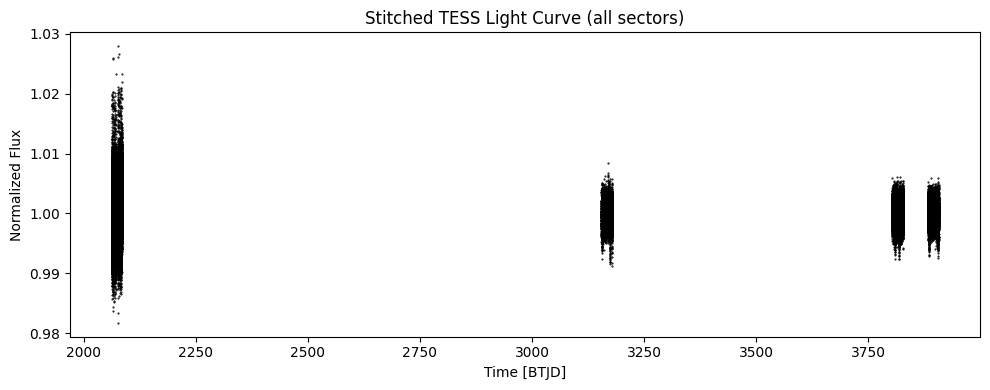

In [8]:
# ============================================
# 拼接所有 sector 的 light curve
# ============================================
import matplotlib.pyplot as plt

def stitch_all_sectors(sector_data):
    """
    输入: sector_data 字典, 形如:
        { (sector_num, exptime): LightCurve, ... }
    输出: 拼接后的单个 LightCurve (按 sector/时间排序)
    """
    # 1. 按 (sector_num, exptime) 排序

    lc_all = None
    for key in sector_data.keys():
        lc = sector_data[key]
        print(f"Appending sector {key[0]} (exptime={key[1]}) with {len(lc.time)} points")
        if lc_all is None:
            lc_all = lc
        else:
            # LightKurve 自带 append 方法, 会直接按时间拼接
            lc_all = lc_all.append(lc)

    return lc_all


# 实际调用
lc_all = stitch_all_sectors(sector_data)

# 画一下拼接后的光变曲线
plt.figure(figsize=(10,4))
plt.plot(lc_all.time.value, lc_all.flux.value, ".k", ms=1)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Stitched TESS Light Curve (all sectors)")
plt.tight_layout()
plt.show()


In [12]:
lc_all = sector_data[(68,120)]
lc_all = lc_all.append(sector_data[(92,120)])
lc_all = lc_all.append(sector_data[(95,120)])


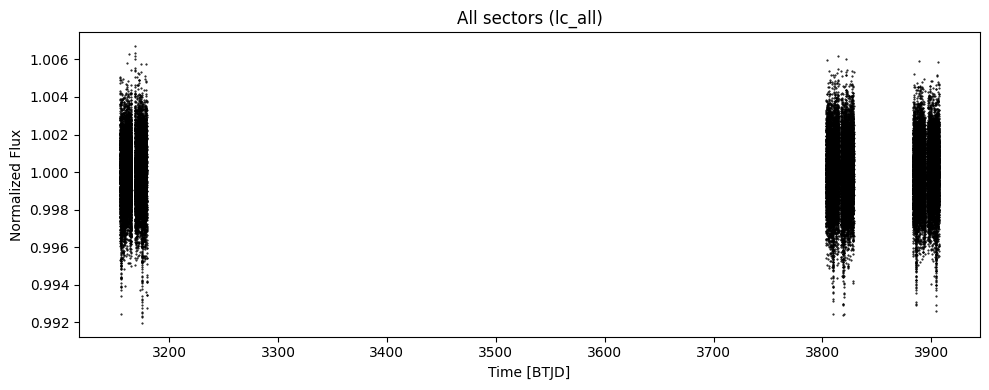

sample: 100%|██████████| 3000/3000 [13:07:31<00:00, 15.75s/it, 1023 steps of size 1.12e-05. acc. prob=0.94]    


Global fit results:
  P        = 10.38325852 ± 0.00003768 days
  t0       = 3508.995872 ± 0.002471 BTJD
  duration = 0.2688 ± 0.0000 days
  r        = 0.0408
  b        = 0.6975
  sigma    = 0.000349 ± 0.000002


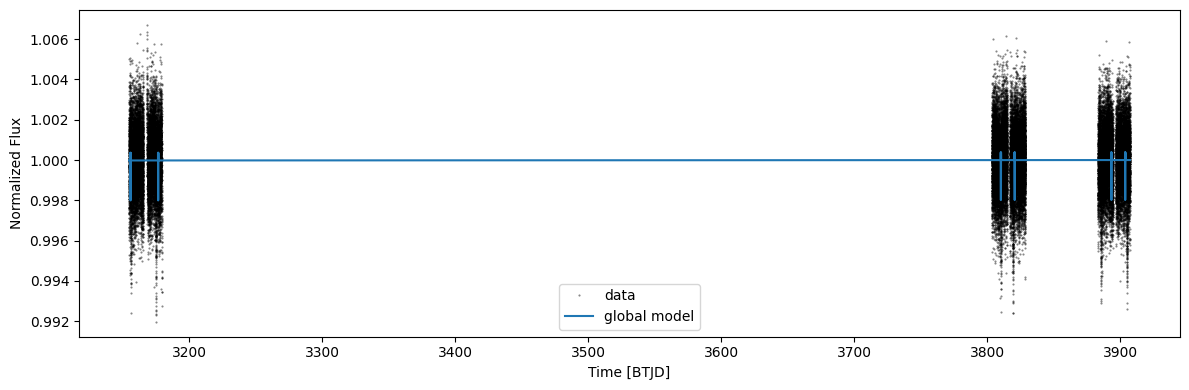

In [14]:
# ============================================
# 0. 导入依赖 & 从 lc_all 取出全局光变
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

# JAX / NumPyro 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# lc_all: 你之前 append 好的、包含所有 sector 的 light curve
# 例如：
# lc_all = None
# for lc in sector_data.values():
#     lc_all = lc if lc_all is None else lc_all.append(lc)

lc_g = (lc_all
        .remove_nans()
        .remove_outliers(sigma=5)
        .normalize())

time_np = lc_g.time.value
flux_np = lc_g.flux.value

if lc_g.flux_err is not None:
    err_np = lc_g.flux_err.value
else:
    # 没有误差就用全局 σ 当常数误差
    sigma_all = float(np.std(flux_np))
    err_np = np.ones_like(flux_np) * sigma_all

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=1)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("All sectors (lc_all)")
plt.tight_layout()
plt.show()


# ============================================
# 1. 全局 transit 模型（不裁剪、不折叠）
#    自由参数：P, t0, duration, r, b, u1, u2, c0, c1, sigma
# ============================================
def transit_model_global(t, yerr, y=None):
    t_ref = t.mean()

    # --- 周期 P：log-uniform 先验 ---
    P_min = 8.0
    P_max = 11.0
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(P_min), jnp.log(P_max)))
    P = numpyro.deterministic("P", jnp.exp(logP))

    # --- t0：某一次 transit 的中心时间 ---
    t0 = numpyro.sample("t0", dist.Uniform(t.min(), t.max()))

    # --- duration：log-uniform ---
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.6)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # --- 几何参数 ---
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))   # Rp/R*
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # --- limb darkening ---
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    # --- 周期性 transit 轨道 ---
    orbit = TransitOrbit(
        period=P,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # 这里 limb_dark_light_curve 返回的是 "Δflux"：
    #   out-of-transit ≈ 0
    #   in-transit < 0
    transit_delta = limb_dark_light_curve(orbit, u)(t)

    # --- baseline: 全局线性 ---
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.5))
    baseline = c0 + c1 * (t - t_ref)

    # ✅ 正确的组合方式：baseline * (1 + Δflux)
    model = baseline * (1.0 + transit_delta)

    # --- 噪声：让模型自己拟合一个额外的 jitter σ ---
    log_sigma = numpyro.sample(
        "log_sigma",
        dist.Uniform(jnp.log(1e-6), jnp.log(1.0))
    )
    sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma))

    total_err = jnp.sqrt(yerr**2 + sigma**2)

    numpyro.sample("obs", dist.Normal(model, total_err), obs=y)


# ============================================
# 2. 跑 MCMC，拟合全局参数（包括 sigma）
# ============================================
def fit_global(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_global)
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=1000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    P_s    = np.array(samples["P"])
    t0_s   = np.array(samples["t0"])
    D_s    = np.array(samples["duration"])
    r_s    = np.array(samples["r"])
    b_s    = np.array(samples["b"])
    sig_s  = np.array(samples["sigma"])

    P_mean, P_std     = float(P_s.mean()), float(P_s.std())
    t0_mean, t0_std   = float(t0_s.mean()), float(t0_s.std())
    D_mean, D_std     = float(D_s.mean()), float(D_s.std())
    r_mean            = float(r_s.mean())
    b_mean            = float(b_s.mean())
    sigma_mean        = float(sig_s.mean())
    sigma_std         = float(sig_s.std())

    print("Global fit results:")
    print(f"  P        = {P_mean:.8f} ± {P_std:.8f} days")
    print(f"  t0       = {t0_mean:.6f} ± {t0_std:.6f} BTJD")
    print(f"  duration = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r        = {r_mean:.4f}")
    print(f"  b        = {b_mean:.4f}")
    print(f"  sigma    = {sigma_mean:.6f} ± {sigma_std:.6f}")

    return (P_mean, t0_mean, D_mean, sigma_mean), samples


(P_best, t0_best, D_best, sigma_best), samples_global = fit_global(
    time_np, flux_np, err_np, seed=42
)


# ============================================
# 3. 用后验均值画“全局模型 vs 全部数据”
# ============================================
def plot_global_model(time_array, flux_array, samples):
    t = jnp.array(time_array)

    P_post  = float(np.array(samples["P"]).mean())
    t0_post = float(np.array(samples["t0"]).mean())
    D_post  = float(np.array(samples["duration"]).mean())
    r_post  = float(np.array(samples["r"]).mean())
    b_post  = float(np.array(samples["b"]).mean())
    u1_post = float(np.array(samples["u1"]).mean())
    u2_post = float(np.array(samples["u2"]).mean())
    c0_post = float(np.array(samples["c0"]).mean())
    c1_post = float(np.array(samples["c1"]).mean())
    u_post  = jnp.array([u1_post, u2_post])

    t_ref = t.mean()

    orbit = TransitOrbit(
        period=P_post,
        duration=D_post,
        time_transit=t0_post,
        impact_param=b_post,
        radius_ratio=r_post,
    )

    # 同样这里是 Δflux
    transit_delta = limb_dark_light_curve(orbit, u_post)(t)
    baseline      = c0_post + c1_post * (t - t_ref)

    # ✅ 还是 baseline * (1 + Δflux)
    model = np.array(baseline * (1.0 + transit_delta))

    plt.figure(figsize=(12, 4))
    plt.plot(time_array, flux_array, ".k", ms=1, alpha=0.5, label="data")
    plt.plot(time_array, model, "-", lw=1.5, label="global model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Normalized Flux")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_global_model(time_np, flux_np, samples_global)


In [ ]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# =============== 0. 基本信息设置 ===============
tic_id = "TIC 123456789"  # TODO：换成你的目标 ID
sector = 92               # 我们就用你说的 92 号 sector

# 你大概知道的轨道参数（为了 mask transit 用）
P_guess = 9.4772          # 例子：周期（天），你可以换
t0_guess = 2459000.1234   # 例子：某个 mid-transit (BJD_TDB)，自行替换

# =============== 1. 从 SPOC 下载 sector 92 光变 ===============
search = lk.search_lightcurve(tic_id, mission="TESS", sector=sector)
if len(search) == 0:
    raise RuntimeError(f"找不到 {tic_id} 的 TESS sector {sector} 光变")

lc = search.download()  # 单个文件：包含 SAP & PDCSAP

# 提取 PDCSAP 光变（已经经过 SPOC PDC）
lc_pdc = lc.PDCSAP_FLUX.remove_nans()

print(lc_pdc)

# =============== 2. 先看一眼原始 PDCSAP ===============
plt.figure(figsize=(10, 4))
lc_pdc.scatter(label="PDCSAP (raw)")
plt.xlabel("Time [BTJD]")
plt.ylabel("Flux [e-/s]")
plt.legend()
plt.title(f"{tic_id}  Sector {sector}  PDCSAP light curve")
plt.show()

# =============== 3. 标记 transit 区域，用于做 flatten 时 mask ===============
# TESS 时间通常是 BTJD = BJD - 2457000
time_btjd = lc_pdc.time.value

# 把 t0_guess 也转成 BTJD
t0_btjd = t0_guess - 2457000.0

phase = ((time_btjd - t0_btjd + 0.5 * P_guess) % P_guess) - 0.5 * P_guess
# 这里假设 transit 持续 ~ 0.3 天，我们取个稍大窗口来 mask
in_transit = np.abs(phase) < 0.2

# =============== 4. 在 PDCSAP 上做长趋势 flatten（mask 掉 transit） ===============
# window_length 可以根据数据点数调，太小会吃掉物理变化；太大则剩下趋势
flat_lc = lc_pdc.flatten(
    window_length=401,   # 大约对应若干小时~1天级别趋势
    polyorder=2,
    break_tolerance=5,
    mask=in_transit      # ⭐关键：不要让拟合看见 transit，本质上在保护 TTV
)

# 正规化 + 去极端 outlier
flat_lc = flat_lc.normalize().remove_outliers(sigma=6)

# =============== 5. 对比：PDCSAP vs 再降噪后的光变 ===============
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
lc_pdc.normalize().scatter(s=2)
plt.title(f"{tic_id}  Sector {sector}  PDCSAP (normalized)")
plt.ylabel("Flux")

plt.subplot(2, 1, 2)
flat_lc.scatter(s=2)
plt.title("PDCSAP + extra flatten (for TTV)")
plt.xlabel("Time [BTJD]")
plt.ylabel("Flux")

plt.tight_layout()
plt.show()

# =============== 6. 把每次 transit 切出来给后面 TTV 拟合用 ===============
# 比如我们切 +/- 0.3 天窗口
transit_windows = []
for epoch in range(-5, 50):  # epoch 范围自己调
    t_center = t0_btjd + epoch * P_guess
    m = (time_btjd > t_center - 0.3) & (time_btjd < t_center + 0.3)
    if np.sum(m) < 5:
        continue
    transit_windows.append(flat_lc[m])

# 想看某一次 transit 的效果：
if len(transit_windows) > 0:
    plt.figure(figsize=(6,4))
    tw = transit_windows[0]
    (tw.time.value - tw.time.value.mean())
    plt.scatter(tw.time.value - tw.time.value.mean(), tw.flux, s=10)
    plt.xlabel("Time - t_mid [days]")
    plt.ylabel("Flux")
    plt.title("Example single transit (ready for MCMC fit)")
    plt.show()


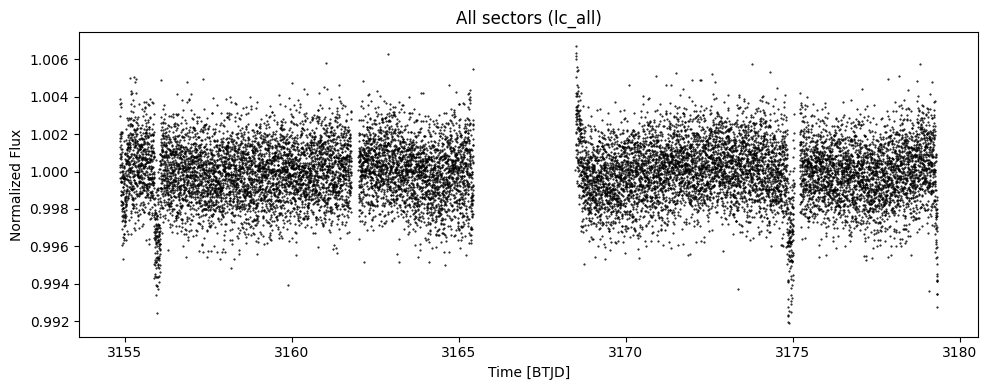

sample: 100%|██████████| 3000/3000 [02:16<00:00, 22.03it/s, 31 steps of size 1.83e-01. acc. prob=0.93]


Global fit results:
  P        = 8.53192684 ± 0.03691958 days
  t0       = 3178.989838 ± 0.066769 BTJD
  duration = 0.5912 ± 0.0090 days
  r        = 0.1742
  b        = 0.2506
  sigma    = 0.989342 ± 0.004939


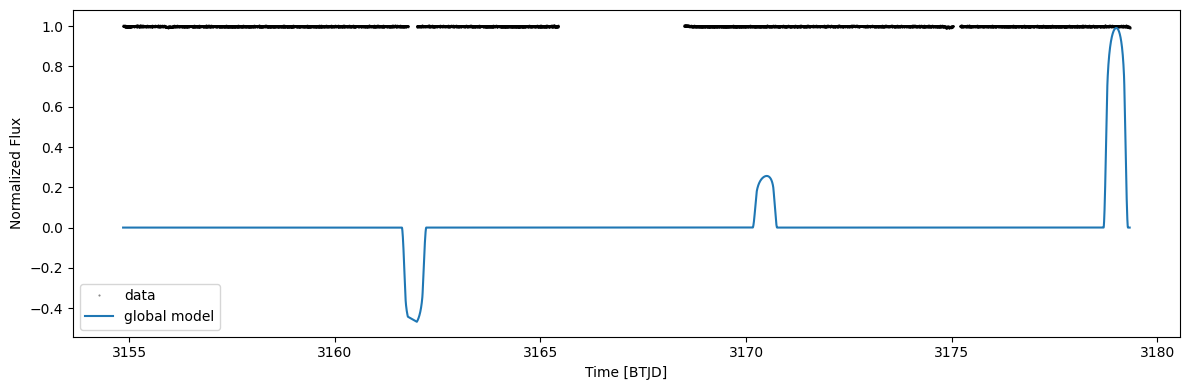

In [10]:
# ============================================
# 0. 导入依赖 & 从 lc_all 取出全局光变
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

# JAX / NumPyro 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# lc_all: 你之前 append 好的、包含所有 sector 的 light curve
# 例如：
# lc_all = None
# for lc in sector_data.values():
#     lc_all = lc if lc_all is None else lc_all.append(lc)

lc_g = (lc_all
        .remove_nans()
        .remove_outliers(sigma=5)
        .normalize())

time_np = lc_g.time.value
flux_np = lc_g.flux.value

if lc_g.flux_err is not None:
    err_np = lc_g.flux_err.value
else:
    # 没有误差就用全局 σ 当常数误差
    sigma_all = float(np.std(flux_np))
    err_np = np.ones_like(flux_np) * sigma_all

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=1)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("All sectors (lc_all)")
plt.tight_layout()
plt.show()


# ============================================
# 1. 全局 transit 模型（不裁剪、不折叠）
#    自由参数：P, t0, duration, r, b, u1, u2, c0, c1, sigma
# ============================================
def transit_model_global(t, yerr, y=None):
    t_ref = t.mean()

    # --- 周期 P：log-uniform 先验 ---
    P_min = 8.0
    P_max = 11.0
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(P_min), jnp.log(P_max)))
    P = numpyro.deterministic("P", jnp.exp(logP))

    # --- t0：某一次 transit 的中心时间 ---
    t0 = numpyro.sample("t0", dist.Uniform(t.min(), t.max()))

    # --- duration：log-uniform ---
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.6)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # --- 几何参数 ---
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))   # Rp/R*
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # --- limb darkening ---
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    # --- 周期性 transit 轨道 ---
    orbit = TransitOrbit(
        period=P,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_lc = limb_dark_light_curve(orbit, u)(t)

    # --- baseline: 全局线性 ---
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.5))
    baseline = c0 + c1 * (t - t_ref)

    model = baseline * transit_lc

    # --- 噪声：让模型自己拟合一个额外的 jitter σ ---
    # 这里给 log_sigma 一个比较宽的先验
    log_sigma = numpyro.sample("log_sigma",
                               dist.Uniform(jnp.log(1e-6), jnp.log(1)))
    sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma))

    # 把你给的 yerr 和 jitter σ 合成总误差
    total_err = jnp.sqrt(yerr**2 + sigma**2)

    numpyro.sample("obs", dist.Normal(model, total_err), obs=y)


# ============================================
# 2. 跑 MCMC，拟合全局参数（包括 sigma）
# ============================================
def fit_global(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_global)
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=1000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    P_s    = np.array(samples["P"])
    t0_s   = np.array(samples["t0"])
    D_s    = np.array(samples["duration"])
    r_s    = np.array(samples["r"])
    b_s    = np.array(samples["b"])
    sig_s  = np.array(samples["sigma"])

    P_mean, P_std     = float(P_s.mean()), float(P_s.std())
    t0_mean, t0_std   = float(t0_s.mean()), float(t0_s.std())
    D_mean, D_std     = float(D_s.mean()), float(D_s.std())
    r_mean            = float(r_s.mean())
    b_mean            = float(b_s.mean())
    sigma_mean        = float(sig_s.mean())
    sigma_std         = float(sig_s.std())

    print("Global fit results:")
    print(f"  P        = {P_mean:.8f} ± {P_std:.8f} days")
    print(f"  t0       = {t0_mean:.6f} ± {t0_std:.6f} BTJD")
    print(f"  duration = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r        = {r_mean:.4f}")
    print(f"  b        = {b_mean:.4f}")
    print(f"  sigma    = {sigma_mean:.6f} ± {sigma_std:.6f}")

    return (P_mean, t0_mean, D_mean, sigma_mean), samples

(P_best, t0_best, D_best, sigma_best), samples_global = fit_global(
    time_np, flux_np, err_np, seed=42
)


# ============================================
# 3. 用后验均值画“全局模型 vs 全部数据”
# ============================================
def plot_global_model(time_array, flux_array, samples):
    t = jnp.array(time_array)

    P_post  = float(np.array(samples["P"]).mean())
    t0_post = float(np.array(samples["t0"]).mean())
    D_post  = float(np.array(samples["duration"]).mean())
    r_post  = float(np.array(samples["r"]).mean())
    b_post  = float(np.array(samples["b"]).mean())
    u1_post = float(np.array(samples["u1"]).mean())
    u2_post = float(np.array(samples["u2"]).mean())
    c0_post = float(np.array(samples["c0"]).mean())
    c1_post = float(np.array(samples["c1"]).mean())
    u_post  = jnp.array([u1_post, u2_post])

    t_ref = t.mean()

    orbit = TransitOrbit(
        period=P_post,
        duration=D_post,
        time_transit=t0_post,
        impact_param=b_post,
        radius_ratio=r_post,
    )
    transit_lc = limb_dark_light_curve(orbit, u_post)(t)
    baseline   = c0_post + c1_post * (t - t_ref)
    model      = np.array(baseline * transit_lc)

    plt.figure(figsize=(12, 4))
    plt.plot(time_array, flux_array, ".k", ms=1, alpha=0.5, label="data")
    plt.plot(time_array, model, "-", lw=1.5, label="global model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Normalized Flux")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_global_model(time_np, flux_np, samples_global)


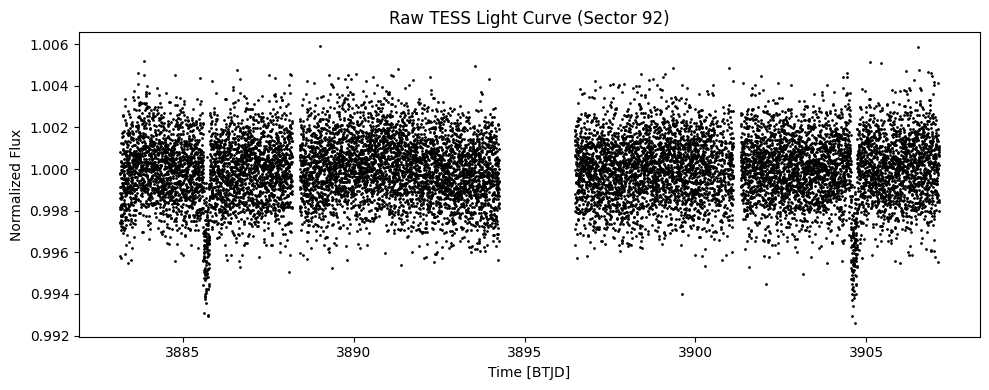

global sigma = 0.0015682571101933718 prominence min = 0.004704771330580115
找到的候选谷值个数: 38
候选时间: [3883.38874592 3883.99292182 3884.7609878  3885.22488223 3885.73460987
 3886.24155904 3886.67628478 3887.21239956 3887.64017975 3888.09712627
 3888.75129501 3889.3624071  3889.79296278 3890.37629555 3890.90407209
 3891.39018144 3891.91101222 3892.33462075 3892.77628425 3893.42488989
 3894.20682685 3897.0359754  3897.78041406 3898.43874107 3899.02901222
 3899.60261603 3900.28177297 3900.89565208 3901.58175116 3902.06785304
 3902.68450715 3903.14977484 3903.84559207 3904.68445992 3905.18027998
 3905.99275692 3906.59690551 3907.08855715]
Transit candidates: 3885.7346098721328 3904.6844599190654


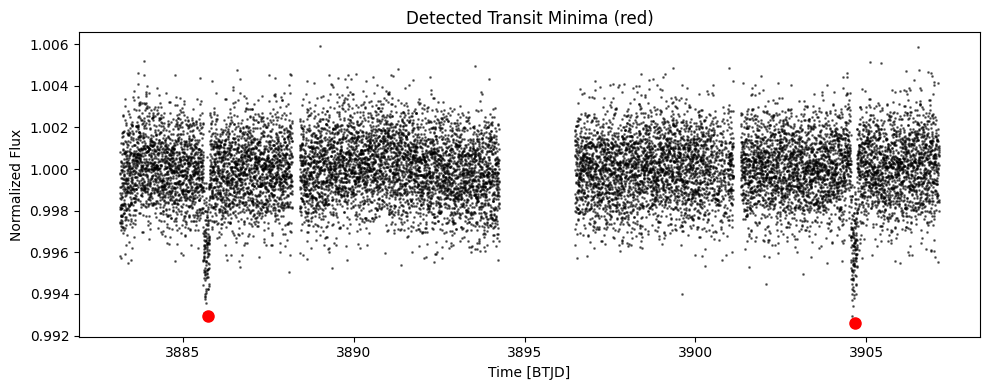

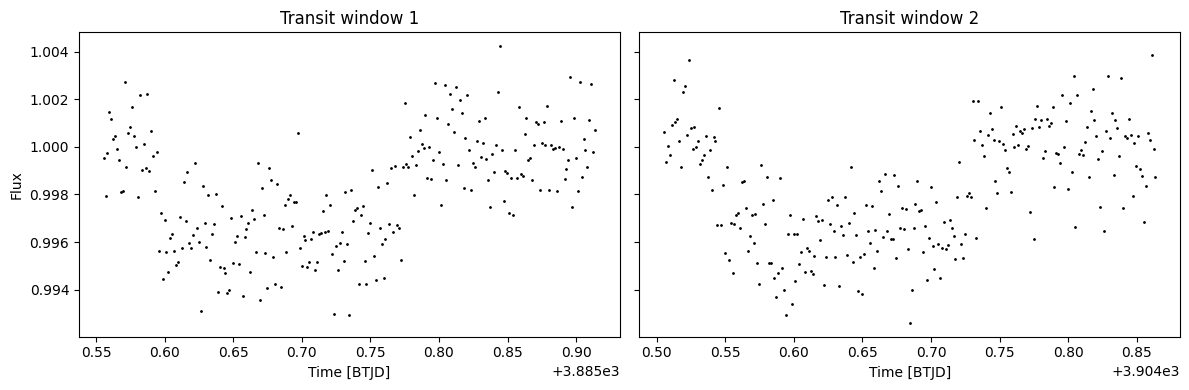

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [02:13<00:00, 26.31it/s, 67 steps of size 1.21e-02. acc. prob=0.93] 


  t0 = 3885.607298 ± 0.000045
  r  = 0.1600
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [02:19<00:00, 25.12it/s, 99 steps of size 6.89e-03. acc. prob=0.92]  


  t0 = 3904.557625 ± 0.000050
  r  = 0.1594
  b  = 1.0000
  u1 = 1.0000, u2 = 1.0000

Transit 1 center time: 3885.607298 ± 0.000045
Transit 2 center time: 3904.557625 ± 0.000050
Difference (approx period): 18.950327 days


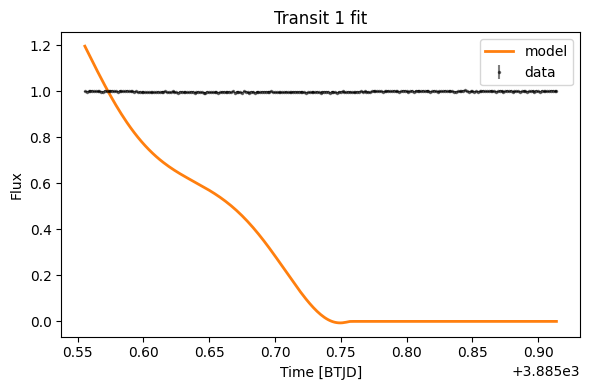

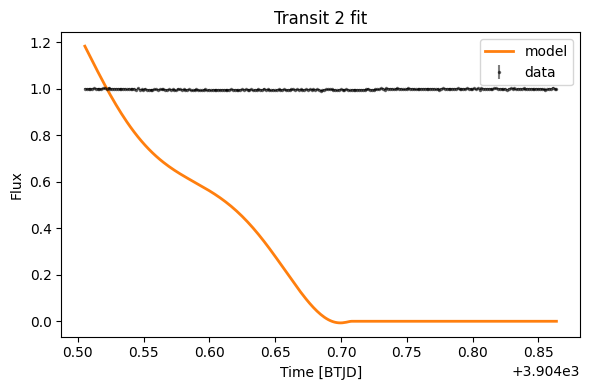

In [16]:
#单sector拟合


# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks



# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


# ============================================
# 1. 取出 Sector 92 的真实光变
#    （如果你的 key 是 (92, 120.0)，改这里）
# ============================================
lc = sector_data[(95,120)]

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()


# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（注意键名是 "prominences"）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化检查一下是不是两次真正的 transit
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
#    window 稍微大一点，baseline 拟合更稳定
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.18):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.18)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.18)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


# ============================================
# 4. 局部 transit 模型：
#    自由参数：t0, duration, r, b, u1, u2, c0, c1
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    # duration：log-uniform 先验
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # ⭐ r: 半径比，Uniform(0.01, 0.2)
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # ⭐ b: impact parameter，通过 b_raw ∈ [-1,1] 再 abs 映射到 [0,1]
    b_raw = numpyro.sample("b_raw", dist.Uniform(-1.0, 1.0))
    b = numpyro.deterministic("b", jnp.abs(b_raw))

    # ⭐ limb darkening: Beta(2,2)，物理上合理的 [0,1] 内分布
    u1 = numpyro.sample("u1", dist.Beta(2.0, 2.0))
    u2 = numpyro.sample("u2", dist.Beta(2.0, 2.0))
    u = jnp.array([u1, u2])

    orbit = TransitOrbit(
        period=10.0,          # dummy，不影响局部几何
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )
    transit_model = limb_dark_light_curve(orbit, u)(t)

    # baseline = c0 + c1 * (t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.02))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 1.0))
    baseline = c0 + c1 * (t - t_center)

    model = baseline * transit_model

    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


# ============================================
# 5. 小工具：给一段光变，返回 t0 / r / b / u 等的后验均值、标准差和 samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())

    r_mean  = float(np.array(samples["r"]).mean())
    b_mean  = float(np.array(samples["b"]).mean())
    u1_mean = float(np.array(samples["u1"]).mean())
    u2_mean = float(np.array(samples["u2"]).mean())

    print(f"  t0 = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  r  = {r_mean:.4f}")
    print(f"  b  = {b_mean:.4f}")
    print(f"  u1 = {u1_mean:.4f}, u2 = {u2_mean:.4f}")

    return t0_mean, t0_std, samples


# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit，肉眼检查一下
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    u1_post = float(np.mean(np.array(samples["u1"])))
    u2_post = float(np.mean(np.array(samples["u2"])))
    u_post  = jnp.array([u1_post, u2_post])

    t_center = t.mean()
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )
    transit_model = limb_dark_light_curve(orbit, u_post)(t)
    baseline = c0_post + c1_post * (t - t_center)
    model = np.array(baseline * transit_model)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array, yerr=np.std(flux_array), fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")

